# Setup
In this notebook, we will exemplify the use of the Beta-Binomial model for Bayesian estimation. The code bellow uses functionalities from Matplotlib, Numpy, Pandas, and Sympy packages.

In [1]:
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym

sym.init_printing()

# Introduction

As a motivating example, imagine yourself scanning through the list of movies on your favorite streaming service, hoping to find a film that you'll enjoy. It's getting late and you're too lazy to start reading through the plot summaries. Though every person has his subjective taste, the wisdom of the crowd, expressed in the average rating of the film, can often provide a pretty good indication of its quality. Therefore, you simply sort the list according to the rate of positive reviews for each film. However, after doing that, you notice something weird. Some of the top-rated films have only a few reviews. Should you prefer a film with a 100% positive rating, but only 5 reviews, or a film with 85% positive rating and 1000 reviews?

The Beta-Binomial model can be used to resolve this ambiguity.




# Beta-Binomial Model

Let's assume for simplicity that every review can only be either positive or negative. In such a binary setting, the list of reviews for a single movie can be seen as the result of a set of $N$ independent Bernoulli trials, out of which $K$ produced positive reviews and $N−K$ resulted in a negative review. The total number of positive reviews can be therefore be modeled as a binomial random variable. The chance for each review to be positive, which will denote as $\theta∈[0,1]$, is determined by the intrinsic quality of the film. In the Bayesian approach, $\theta$ is also modeled as a random variable, with some prior distribution. A highly suitable candidate for the prior distribution is the Beta distribution. As it will be shown next, the selection of Beta distribution as the prior results in a very elegant derivation for the estimator of $\theta$. 

More formally, the prior $P(\theta;a,b)$ and the likelihood $P(K|\theta;N)$ Beta-Binomial model can be described as follows:

$$\theta \sim Beta(a,b),\;\; P(\theta;a,b) = \frac{1}{\beta(a,b)}\theta^{a-1}(1-\theta)^{b-1}$$

$$K|\theta \sim Binomial(N,\theta),\;\; P(K|\theta;N) = \frac{N!}{K!(N-K)!}\theta^{K}(1-\theta)^{N-K}$$

# Obtaining Prior Model Parameters

We can obtain an initial (prior) estimate of the distribution of $\theta$ by analyzing a large set of film ratings. Here we will use the [TMDB 5000 Movie Dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata/data#tmdb_5000_movies.csv) for this purpose. This dataset contains information about user votes (on the scale of 1-10) for over 4800 popular movies. For our analysis will use only records with over 100 user votes, assuming that such a number of reviews is sufficient to be truly representative of the actual quality of the film.

The following code loads the relevant data, normalizes the scores, and selects the records which satisfy the criteria described above.

In [2]:
base_path = '../data/'
movies_path = base_path + 'tmdb_5000_movies.csv'
credits_path = base_path + 'tmdb_5000_credits.csv'

titles = pd.read_csv(credits_path, usecols=['movie_id', 'title'])
votes = pd.read_csv(movies_path, usecols=['id', 'vote_count', 'vote_average'])
ratings = pd.merge(titles, votes, how='inner', left_on='movie_id', right_on='id')
ratings.drop(columns=['id', 'movie_id'], inplace=True)
ratings['vote_average'] /=  10
ratings = ratings.loc[ratings['vote_count'] > 100]
ratings.head(10)

,title,vote_average,vote_count
0,Avatar,0.72,11800
1,Pirates of the Caribbean: At World's End,0.69,4500
2,Spectre,0.63,4466
3,The Dark Knight Rises,0.76,9106
4,John Carter,0.61,2124
5,Spider-Man 3,0.59,3576
6,Tangled,0.74,3330
7,Avengers: Age of Ultron,0.73,6767
8,Harry Potter and the Half-Blood Prince,0.74,5293
9,Batman v Superman: Dawn of Justice,0.57,7004


In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3150 entries, 0 to 4798
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         3150 non-null   object 
 1   vote_average  3150 non-null   float64
 2   vote_count    3150 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 98.4+ KB


As it can be seen, we are left with a fairly large amount of data, which can be used for estimating the parameters of the prior. To determine the values of $a$ and $b$ we will use a very simple parametric density estimation technique. We'll compute the empiric mean and variance across the movies in our dataset and derive the parameters of the Beta distribution which will have the same characteristics. This task can be easily accomplished analytically using the Sympy package.

First, we will construct the symbolic representation for the prior.

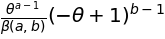

In [4]:
a, b, theta = sym.symbols('a b theta')
prior = sym.S(theta**(a-1) * (1-theta)**(b-1)) / sym.beta(a,b)
display(prior)

The following expression  describes the mean and the variance of the prior in terms of $a$ and $b$ ([source](https://en.wikipedia.org/wiki/Beta_distribution)):
$$\mu = \frac{a}{a+b}$$

$$v = \frac{ab}{(a+b)^2(a+b+1)} $$

We can use Sympy to obtain the inverse relation.

In [5]:
mu, v = sym.symbols('mu v')
eq1 = sym.Eq(mu, sym.S(a)/(a+b))
eq2 = sym.Eq(v, sym.S(a * b) / ((a + b)**2 * (a + b + 1)))
solution = sym.solve([eq1, eq2], [a, b])
expr_a = solution[0][0]
expr_b = solution[0][1]

display(sym.Eq(a, expr_a))
display(sym.Eq(b, expr_b))

Next, we'll plug in the empiric mean and variance from our dataset into these inverse relations, to obtain the parameters of our prior:

In [6]:
emp_mean = ratings['vote_average'].mean()
emp_var = ratings['vote_average'].var()
print(f'Empirical mean score: {emp_mean:.4f}')
print(f'Empirical variance of scores: {emp_var:.4f}')

a_emp = expr_a.subs({mu: emp_mean, v: emp_var}).evalf()
b_emp = expr_b.subs({mu: emp_mean, v: emp_var}).evalf()
a_emp, b_emp = float(a_emp), float(b_emp)

print(f'Value for parameter a: {a_emp:.4f}')
print(f'Value for parameter b: {b_emp:.4f}')

Empirical mean score: 0.6356
Empirical variance of scores: 0.0070
Value for parameter a: 20.5183
Value for parameter b: 11.7630


Let's see how does the resulting probability density function compare with the normalized histogram of scores from our dataset:

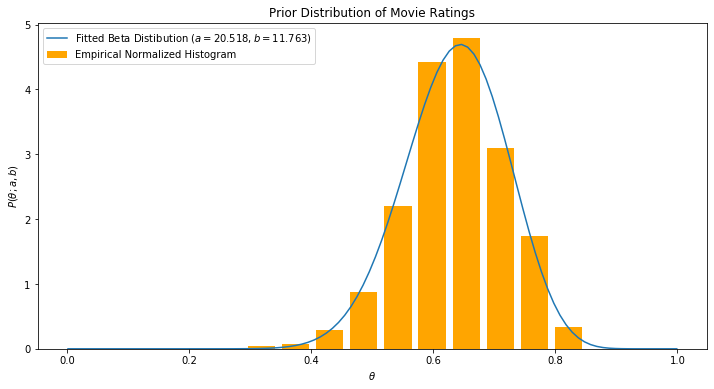

In [7]:
density, bin_edges = np.histogram(ratings['vote_average'].to_numpy(), density=True)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[:-1] + bin_width / 2

fig, ax = plt.subplots(figsize=[12,6])
ax.bar(bin_centers, density, width=bin_width * 0.8, color='orange',
       label='Empirical Normalized Histogram')

t = np.linspace(0.001, 0.999, 100)
prior_pdf = sym.lambdify(theta, prior.subs({a: a_emp, b: b_emp}), 'numpy')
ax.plot(t, prior_pdf(t),
        label=f'Fitted Beta Distibution ($a={a_emp:.3f}, b={b_emp:.3f}$)')

ax.legend()
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$P(\theta;a,b)$')
ax.set_title('Prior Distribution of Movie Ratings');




The fit looks pretty good.

# Deriving the Posterior Distribution
Let's return to our motivating example. Assume we see that a particular movie has a really high rating, but a small count of votes. How can we estimate what would be its rating if it was evaluated by a large number of viewers? This is exactly where the Bayesian model steps in.

What we are looking for is the estimate of the intrinsic score of a movie given that out of $N$ ratings provided for it, $K$ were positive. In our model, we represent this score by $\theta$ on the scale of 0 to 1. In order to obtain an estimate of $\theta$ we first need to compute the posterior distribution, which can be derived from the Bayes rule as follows:

$$ P(\theta|K;N,a,b) = \frac{P(K|\theta;N)P(\theta;a,b)}{P(K)}$$

It can be seen that the posterior combines both our observation of $K$ (likelihood), and our preliminary knowledge regarding the distribution of movie ratings (prior). The marginal probability $P(k)$ in the denominator is merely a normalization factor. It can be computed by integrating over all possible values of $\theta$:

$$P(K) = \int_{0}^{1} P(K,\theta;N,a,b) d\theta = \int_{0}^{1} P(K|\theta;N)P(\theta;a,b) d\theta $$

We also note that:

$$ P(\theta|K;N,a,b)\; \propto\; \frac{n!}{k!(n-k)!}\theta^{K}(1-\theta)^{N-K}\frac{1}{\beta(a,b)}\theta^{a-1}(1-\theta)^{b-1} \;\propto\; \theta^{a+K-1}(1-\theta)^{b+N-K-1} $$

Which implies that the posterior probability density function $P(\theta|K;N,a,b)$ also has the form of Beta distribution ([full derivation can be found here](http://compcogsci-3016.djnavarro.net/technote_betabinomial.pdf)):

$$\theta|K \sim Beta(a+K, b+N-K)$$

When the posterior ends up having the same distribution as the prior, such a prior then is called a Conjugate Prior. Apparently, the Beta distribution is the conjugate prior for the Bernoulli likelihood.

The nice thing with using a conjugate prior is that it allows us to avoid expensive numerical computations involved in Bayesian inference. Knowing the exact form of the posterior, we can easilly compute the posterior mean $E[\theta|K]$, which is the optimal estimator under the [Mean Square Error criterion](https://en.wikipedia.org/wiki/Minimum_mean_square_error):

$$\hat{\theta}_{opt} = E[\theta|K] = \int_{0}^{1} P(\theta|K;N,a,b) d\theta = \frac{a+K}{a+b+N}$$

This result is obtained by simply using the formula for the mean of the Beta distribution.


# Simulated Experiment

In the following code, we will simulate the behavior of the posterior distribution of the Beta-Binomial model. We will run a set of sequential Bernoulli trials, simulating the addition of reviews for a particular movie. The samples will be drawn using $\theta_{actual}=0.9$, which represents a particularly good movie (recall that the mean of the prior distribution was $E[\theta]\approx 0.64$).

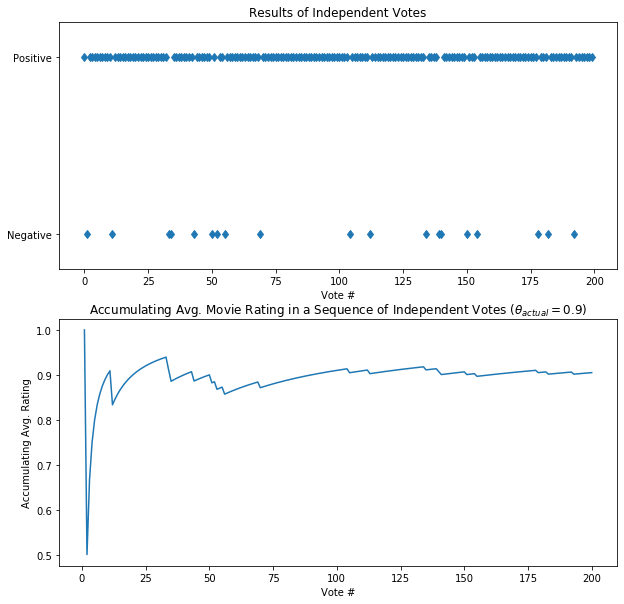

In [8]:
rand_gen = np.random.RandomState(seed = 42)

n_max = 200
theta_actual = 0.9
results = rand_gen.binomial(1, theta_actual, size=n_max)
positives_count = np.add.accumulate(results)
votes_count = np.arange(1,n_max+1)

fig, ax =  plt.subplots(nrows=2, ncols=1, figsize=[10,10])

ax[0].plot(results, 'd')
ax[0].set_ylim(-0.2, 1.2)
ax[0].yaxis.set(ticks=(0,1), ticklabels=('Negative', 'Positive'))
ax[0].set_xlabel('Vote #')
ax[0].set_title('Results of Independent Votes')

ax[1].plot(votes_count, positives_count/votes_count)
ax[1].set_ylabel('Accumulating Avg. Rating')
ax[1].set_xlabel('Vote #')
ax[1].set_title('Accumulating Avg. Movie Rating in a Sequence of Independent Votes' + 
                f' ($\\theta_{{actual}}={theta_actual}$)');



Not surprisingly for a movie with such high $\theta_{actual}$, we can see that the overwhelming majority of the generated ratings are positive. As expected by the law of large numbers, the accumulating average rating converges towards $\theta_{actual}$ as the number of available votes increases.

Next, we'll apply Bayesian estimation and will compute the posterior at some selected points of the process after 10, 50, 100, and 200 ratings are made available. This way, we could observe the dynamics of the posterior with respect to the prior as the available information increases. 
We will also visualize the likelihood function as well as the distribution of votes at each point. Both the likelihood and the posterior can be evaluated using Sympy, as we've previously done during the computation of the prior.


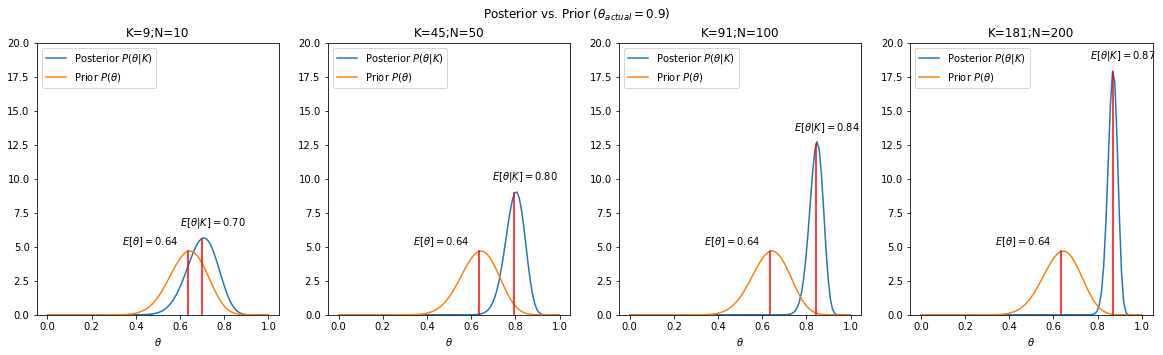

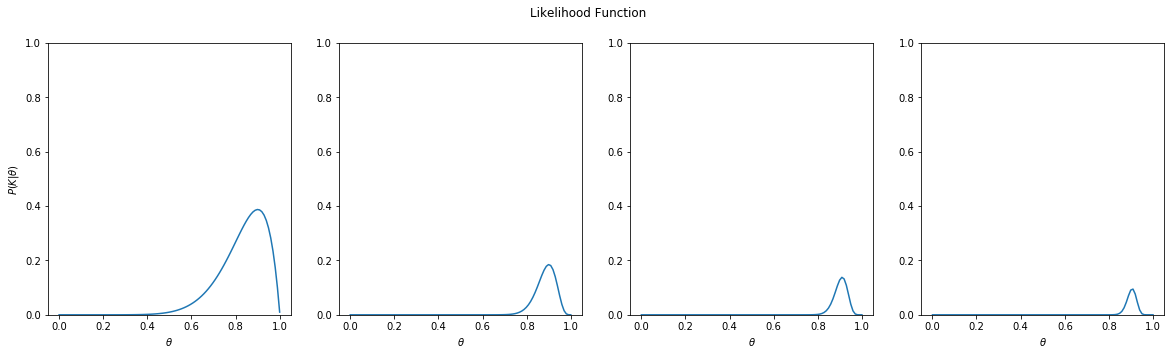

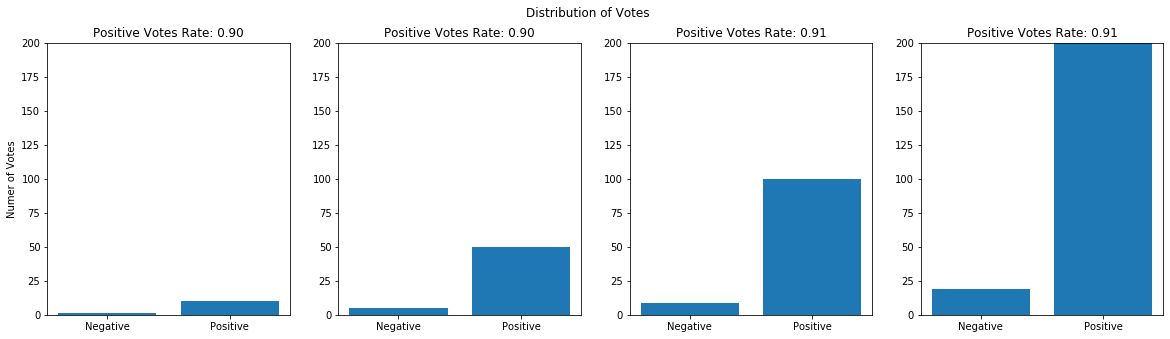

In [9]:
N, K = sym.symbols('N K')
posterior = sym.S(theta**(a+K-1) * (1-theta)**(b+N-K-1)) / sym.beta(a+K, b+N-K)
posterior_pdf = sym.lambdify([theta, K, N], posterior.subs({a: a_emp, b: b_emp}),
                             modules=['numpy', 'sympy'])

likelihood = sym.S(sym.factorial(N)) / (sym.factorial(K) * sym.factorial(N-K)) *\
                  theta**K * (1-theta)**(N-K)
likelihood_func = sym.lambdify([theta, K, N], likelihood.subs({a: a_emp, b: b_emp}),
                               modules=['numpy', 'sympy'])

bayes_estimator = sym.S(a + K) / (a + b + N)
posterior_mean = sym.lambdify([K, N], bayes_estimator.subs({a: a_emp, b: b_emp}))

estimation_points = np.array([10, 50, 100, 200])
t = np.linspace(0.001, 0.999, 100)
prior_vec = prior_pdf(t)
prior_peak = prior_pdf(emp_mean)

fig1, ax1 = plt.subplots(nrows=1, ncols=len(estimation_points), figsize=[20,5])
fig1.suptitle(f'Posterior vs. Prior ($\\theta_{{actual}}={theta_actual}$)')

fig2, ax2 = plt.subplots(nrows=1, ncols=len(estimation_points), figsize=[20,5])
fig2.suptitle('Likelihood Function')

fig3, ax3 = plt.subplots(nrows=1, ncols=len(estimation_points), figsize=[20,5])
fig3.suptitle('Distribution of Votes')

f_max = 20    # used for scaling of y-axis in plots of PDFs

for i, (n, k) in enumerate(zip(estimation_points,
                               positives_count[estimation_points-1])):
  theta_opt = posterior_mean(k, n)
  ax1[i].plot(t, posterior_pdf(t, k, n), label=f'Posterior $P(\\theta|K)$')
  ax1[i].plot(t, prior_vec, label=f'Prior $P(\\theta)$')

  posterior_peak = posterior_pdf(theta_opt, k, n)
  ax1[i].axvline(theta_opt, ymin=0, ymax=posterior_peak/f_max, color='r')
  ax1[i].text(theta_opt-0.1, posterior_peak+1, f'$E[\\theta|K]={theta_opt:.2f}$')

  ax1[i].axvline(emp_mean, ymin=0, ymax=prior_peak/f_max, color='r')
  ax1[i].text(emp_mean-0.3, prior_peak+0.5, f'$E[\\theta]={emp_mean:.2f}$')

  ax1[i].set_title(f'K={k};N={n}')
  ax1[i].legend(loc='upper left')
  ax1[i].set_ylim(0, f_max)
  ax1[i].set_xlabel('$\\theta$')

  ax2[i].plot(t, likelihood_func(t,k,n))
  ax2[i].set_ylim(0, 1)
  ax2[i].set_xlabel('$\\theta$')
  if i == 0:
    ax2[i].set_ylabel('$P(K|\\theta)$')
  
  ax3[i].bar([0, 1], [n-k, n])
  ax3[i].xaxis.set(ticks=(0,1), ticklabels=('Negative', 'Positive'));
  ax3[i].set_ylim(0, n_max)
  ax3[i].set_title(f'Positive Votes Rate: {k/n:.2f}')
  if i == 0:
    ax3[i].set_ylabel('Numer of Votes')

# Conclusion

If we only have a small sample of ratings for the film, our best estimate would be fairly close to the prior mean $E[\theta]$. Yet, as more information becomes available, our prior becomes less valuable. With the increase in the number of ratings, the likelihood function pulls the posterior mean $E[\theta|K]$ away from the prior and closer towards $\theta_{actual}$. The transform of the posterior into a sharper shaped curve implies higher certainty and lower expected estimation error.